# 3_view_thalamus_gene_expression

This notebook demonstrates how to use the custom plotting functions found in the
`thalamus_merfish_analysis\ccf_plots.py` module to view spatial gene expression 
measured by MERFISH in the thalamus and zona incerta.

Part 1: View Thalamus-wide Gene Expression

Part 2: Find & View DEGs (Differentialy Expressed Genes) 

Part 3: View HCR / Multi-Gene Experiment Simulation

In [14]:
from importlib_resources import files
import anndata as ad
import pandas as pd
import numpy as np

import scanpy as sc

from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots

import matplotlib.pyplot as plt
%matplotlib inline

## Set figure generation behavior

In [15]:
# This notebook takes awhile to run if you're displaying all the DEGs found
# herein, so you can set this variable to control global figure display behavior

# number of DEGs to plot 
n_de_genes_to_plot = 2 # suggested to minimize runtime: 2

## Load thalamus dataset

Since we want to view gene expression, we need to load the full AnnData object.

For details on the AnnData output of `load_standard_thalamus()`, please see `1_load_thalamus_data.ipynb`.

In [16]:
# load AnnData object so we have the gene expression
# standard behavior loads in log2cpt (counts per thousand) gene counts, which are suitable for both
# DEG analysis and gene expression display
adata_th_log2cpt = abc.load_standard_thalamus(data_structure='adata')
adata = adata_th_log2cpt

/root/capsule/code/thalamus_merfish_analysis/abc_load_base.py:336: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cells_df = cells_df.replace("ZI-unassigned", "ZI")


### set spatial coordinates

Since we have 3 sets of spatial coordinates (`_section`, `_reconstructed`, and `_ccf`), we need to specify which coordinate space we wish to work from.

For this notebook, we will work in the `_reconstructed` coordinate space, which is a registration of each MERFISH section to a target resampled CCF section. 
For more information on the different coordinates, please see: https://alleninstitute.github.io/abc_atlas_access/notebooks/merfish_ccf_registration_tutorial.html

In [17]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

### load Allen Reference Atlas (ARA) structure images & boundaries

To overlay the ARA structures on the cell types found in the thalamus, we need to load the volume & boundary images from the ABC Atlas, which are referred to as 'CCF' from here on out.

In [18]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

In [19]:
# specify CCF parcellation level column in adata.obs
ccf_label = 'parcellation_substructure'

In [20]:
# Precompute boundaries to use multiple times in this notebook w/o need to recompute

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(adata.obs[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

# # Alternative: skip and define as None to calculate on the fly
# ccf_boundaries = None

### load custom cluster color palette

In [21]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['subclass','supertype','cluster']}

# Load custom, contrast-y cluster color palette
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette()

In [22]:
# 3 sections that representatively span the AP axis of the thalamus
sections_3 = [6.4, 7.2, 8.0]

In [23]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

## 1.) View Thalamus-wide Gene Expression

We provide 3 main ways to view thalamus-wide gene expression

1a) Gene expression only

1b) Gene expression + CCF parcellation boundaries overlay

1c) Gene expression + highlight specific CCF parcellation boundar(y/ies)

### 1a) Gene expr only

The `plot_expression_ccf()` function in the `ccf_plots` module displays per-section gene expression of a specified gene.

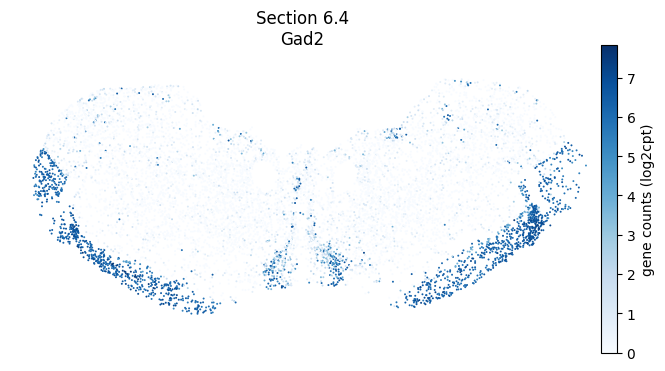

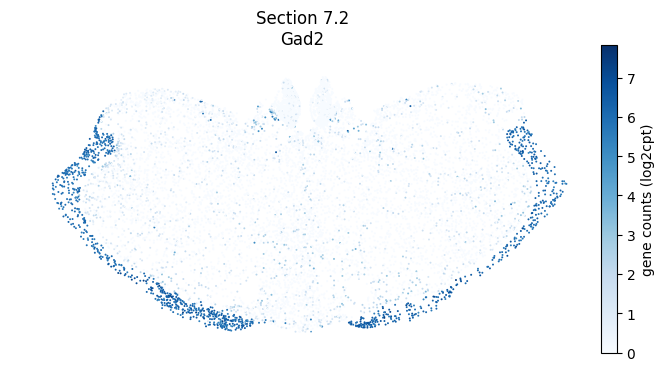

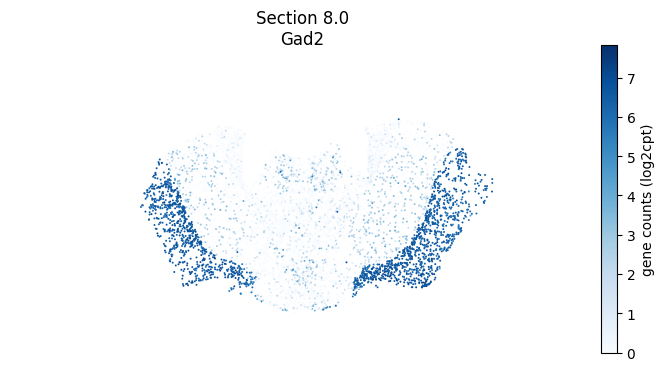

In [24]:
figs = cplots.plot_expression_ccf(adata, # loaded AnnData obj
                                  'Gad2', # the 1 gene to display
                                  ccf_images, # preloaded CCF image volumes
                                  boundary_img=ccf_boundaries, # precalculated for speed
                                  nuclei=[], # does NOT show CCF parcellations
                                  sections=sections_3, # set to None or leave out to plot all available sections
                                                       # to plot single section, wrap in list: e.g. sections=[6.4] 
                                  cmap='Blues', # accepts any matplotlib colormap 
                                  point_size=2,
                                  section_col=section_col, x_col=x_col, y_col=y_col # defined in prior cell
                                  )

### 1b) Gene expr + CCF parcellation overlay

By setting `nuclei=None`, the function will plot all CCF parcellation boundaries over the gene's expression

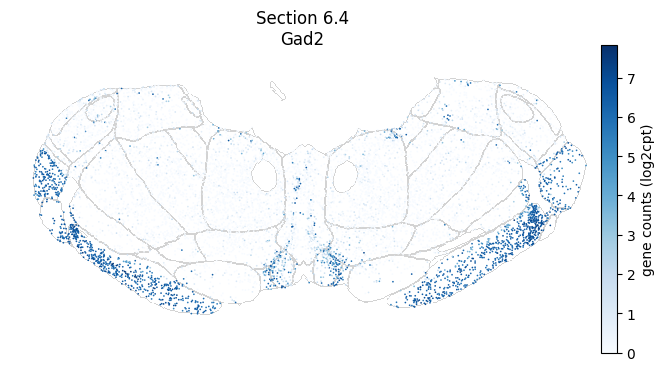

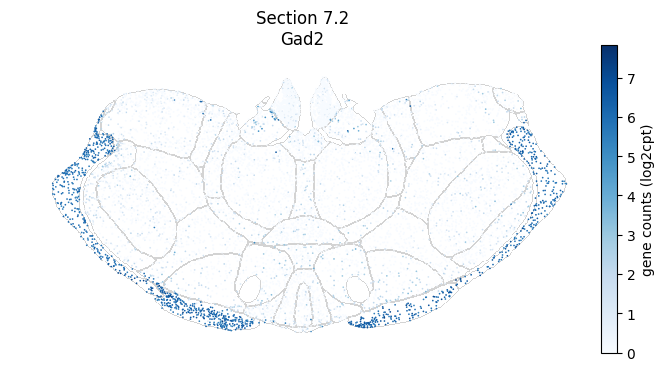

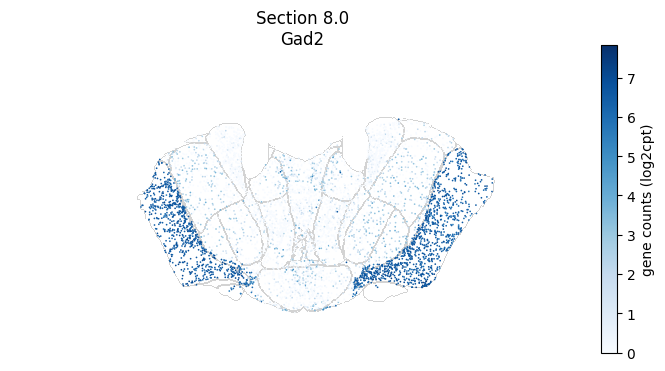

In [25]:
# By setting `nuclei=None` (the default value), the function will plot all CCF parcellation
# boundaries over the gene's expression
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()
figs = cplots.plot_expression_ccf(adata,
                                  'Gad2',
                                  ccf_images,
                                  boundary_img=ccf_boundaries,
                                  nuclei=None, # default, plots all available CCF parcellation structures
                                  sections=sections_3,
                                  cmap='Blues',
                                  section_col=section_col, x_col=x_col, y_col=y_col
                                  )

### 1c) Gene expr + highlight specific CCF structures

By passing a list of CCF substructures to `highlight=['PF', 'AD']`, the 
`plot_expression_ccf()` function will show all CCF parcellation boundaries with 
grey outline and highlight the `highlight` substructures with a black outline

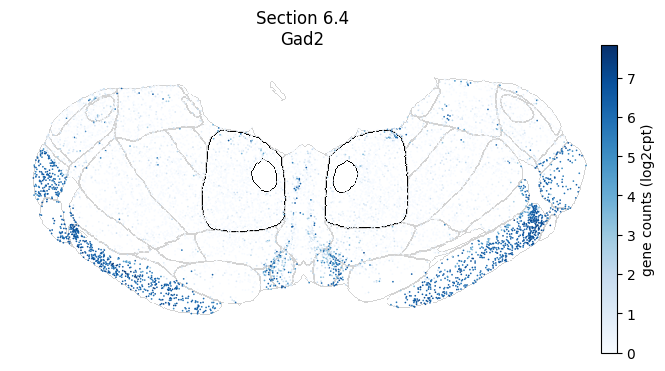

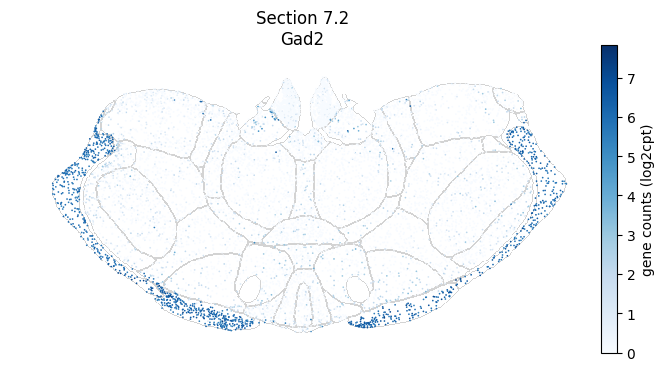

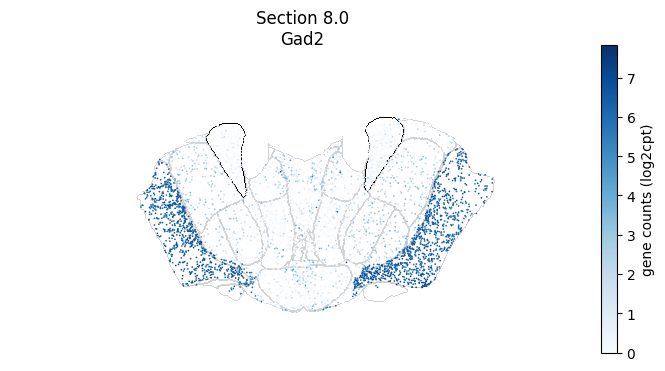

In [26]:
# Pass a list of substructures to `highlight` to highlight them with a black outline
figs = cplots.plot_expression_ccf(adata,
                                  'Gad2',
                                  ccf_images,
                                  boundary_img=ccf_boundaries,

                                  nuclei=None, # default, plots all CCF substructures with grey outline
                                               # set nuclei=[] to plot no background/grey CCF substructures

                                  highlight=['PF', 'AD'], # highlights certain parcellations with black outline
                                                          # to plot one substructure, wrap in list: e.g. highlight=['AV']
                                                          
                                  sections=sections_3,
                                  section_col=section_col, x_col=x_col, y_col=y_col)

## 2.) Find & View DEGs

We performed differential expression analysis with scanpy’s `rank_genes_group` 
function   to identify differentially expressed genes (DEGs) between spatially 
adjacent cell types in the thalamus. 

#### run_sc_deg_analysis()

A helper function to run DEG analysis and format the output

In [27]:
def run_sc_deg_analysis(adata, taxonomy_level, groups='all', reference='rest',
                        n_genes_display=20, rankby_abs=True, method='wilcoxon',
                        save_to_key=None, print_as_lists=True):
            
    # rank genes
    sc.tl.rank_genes_groups(adata, taxonomy_level, groups=groups, 
                            reference=reference, n_genes=None, rankby_abs=True,
                            method=method, key_added=save_to_key)
    
    # change default key if input parameter was set
    if save_to_key==None:
        key='rank_genes_groups'
    else:
        key=save_to_key
    
    # plot top n_genes_display
    sc.pl.rank_genes_groups(adata, n_genes=n_genes_display, key=key)
    
    # print out lists of top DEGs so they can be copy-pasted elsewhere
    if print_as_lists:
        n_genes_print = int(np.floor(n_genes_display/2))

        deg_df = sc.get.rank_genes_groups_df(adata, group=None, key=key)

        degs_top_all = deg_df.head(n_genes_display).names.to_list()
        degs_top_pos = deg_df[deg_df['scores']>0].head(n_genes_print).names.to_list()
        degs_top_neg = deg_df[deg_df['scores']<0].head(n_genes_print).names.to_list()

        print(f'\nTop {n_genes_display} DEGs for {groups} vs {reference}:\n', 
              degs_top_all)
        print(f'\nTop {n_genes_print} positive DEGs for {groups} vs {reference}:\n', 
              degs_top_pos)
        print(f'\nTop {n_genes_print} negative DEGs for {groups} vs {reference}:\n', 
              degs_top_neg)
        
    return degs_top_all, degs_top_pos, degs_top_neg

#### set default plotting kwargs

In [28]:
kwargs_ATN_cells = dict(
    bg_cells=adata.obs,
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=4, 
    face_palette=None,
    edge_color='grey'
    )

kwargs_ATN_expr = dict(
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    cmap='Blues',
    point_size=1,
    edge_color='grey'
    )

### Load cell type : nuclei resource CSV

We generated a CSV file that maps each thalamic nucleus to a manually selected 
set of top clusters, supertypes, and subclasses that map to cells primarily 
within that nucleus’ boundaries.

In [29]:
# load manual cluster annotations for thalamic nuclei
nuclei_cluster_df = abc.nuclei_df_manual
nuclei_cluster_df.head(5)

subclasses_AIT17  \
nuclei                             
AD          065 AD Serpinb7 Glut   
AM      069 TH Prkcd Grin2c Glut   
AV           066 AV Col27a1 Glut   
CM        068 CM-IAD-CL-PCN Glut   
PCN CL    068 CM-IAD-CL-PCN Glut   

                                         supertypes_AIT17  \
nuclei                                                      
AD                                  0257 AD Serpinb7 Glut   
AM      0283 TH Prkcd Grin2c Glut_9, 0282 TH Prkcd Gri...   
AV                                   0258 AV Col27a1 Glut   
CM                              0266 CM-IAD-CL-PCN Glut_2   
PCN CL                          0265 CM-IAD-CL-PCN Glut_1   

             cluster_ids_AIT17           cluster_alias  \
nuclei                                                   
AD                  1095, 1096              5020, 5021   
AM      1169, 1163, 1170, 1171        5041, 5042, 5043   
AV                  1097, 1098              5022, 5023   
CM                                                       
PCN CL  1116, 1115, 1117, 1118  5038, 5036, 5039, 5100   

       cluster_ids_CNN20230720 checked supertypes_CNN20230720  
nuclei                                                         
AD                  2613, 2614     1.0                         
AM            2674, 2675, 2676     1.0                         
AV                  2615, 2616     1.0                         
CM            2636, 2642, 2646     1.0                         
PCN CL        2634, 2633, 2635

### Anterior Thalamic Nuclei (ATN) DEGs

We will use the anterior thalamic nuclei (ATN) as an example of using DEG analysis
to explore and compare the cell types found in the thalamus.

In [30]:
# Use manual nuclei:cluster annotations to grab cells that mapped to major ATN cell types
obs_ATN = abc.get_obs_from_annotated_clusters(['AD', 'AV', 'AM'], adata.obs)

/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py:1017: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(
/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py:1017: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(
/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py:1017: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when deter

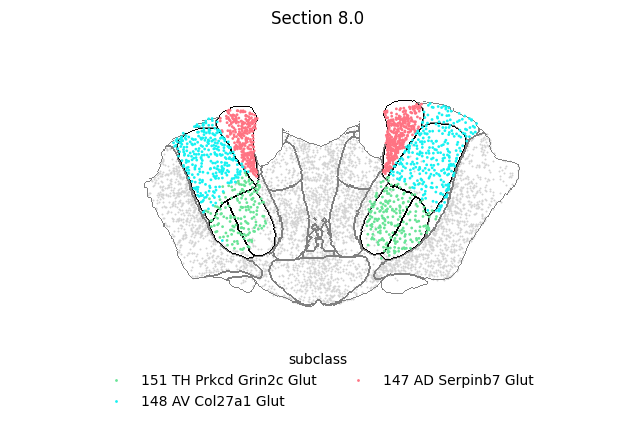

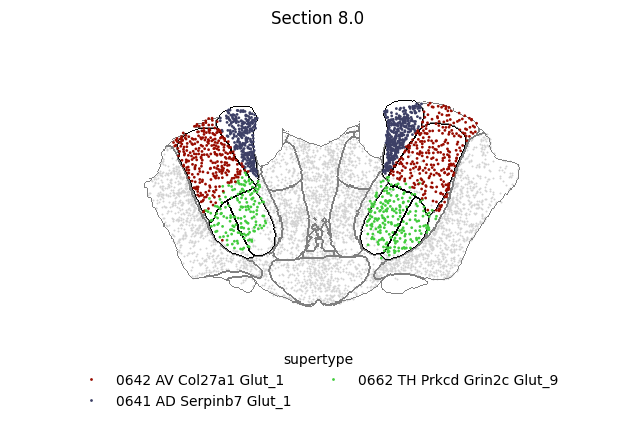

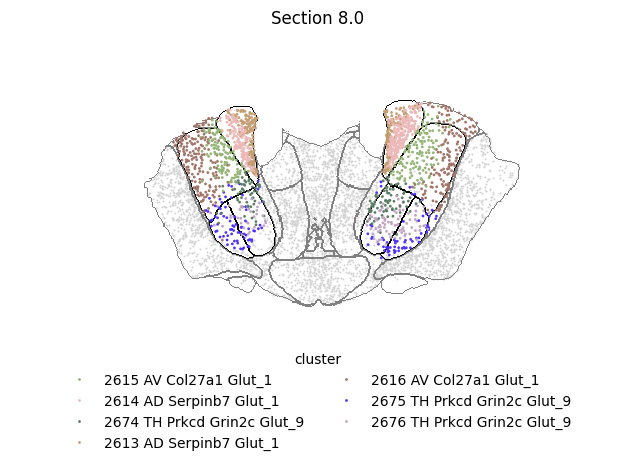

In [31]:
# Let's look at the cell types in the ATN in one sample section
sections_ATN = [8.0]
nuclei_ATN_highlight = ['AD', 'AV', 'AMv', 'AMd']

# show all th
taxonomy_levels = ['subclass','supertype','cluster']
for level in taxonomy_levels:
    figs_ATN = cplots.plot_ccf_overlay(obs_ATN, 
                                        ccf_images, 
                                        ccf_highlight=nuclei_ATN_highlight,
                                        point_hue=level, 
                                        sections=sections_ATN,
                                        point_palette=abc_palettes[level],
                                        legend='cells',
                                        **kwargs_ATN_cells)

#### AD subclass vs. rest of subclasses

We can use scanpy's gene group analysis to compare one group of cells to the 
rest of the cells in the dataset.

Here, since AD has it's own subclass, we compare the AD-specific subclass, by 
setting `groups='147 AD Serpinb7 Glut'`, to the rest of the subclasses in the 
thalamus, by setting `reference='rest'`.

We can then plot the top DEGs that are highly expressed in the AD subclass as
compared to all other subclasses in the thalamus.

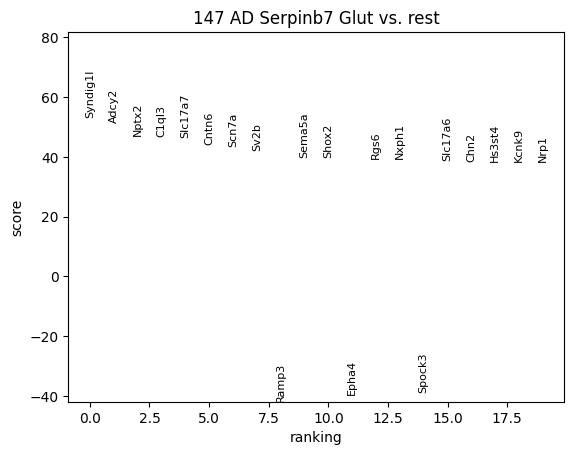


Top 20 DEGs for ['147 AD Serpinb7 Glut'] vs rest:
 ['Syndig1l', 'Adcy2', 'Nptx2', 'C1ql3', 'Slc17a7', 'Cntn6', 'Scn7a', 'Sv2b', 'Ramp3', 'Sema5a', 'Shox2', 'Epha4', 'Rgs6', 'Nxph1', 'Spock3', 'Slc17a6', 'Chn2', 'Hs3st4', 'Kcnk9', 'Nrp1']

Top 10 positive DEGs for ['147 AD Serpinb7 Glut'] vs rest:
 ['Syndig1l', 'Adcy2', 'Nptx2', 'C1ql3', 'Slc17a7', 'Cntn6', 'Scn7a', 'Sv2b', 'Sema5a', 'Shox2']

Top 10 negative DEGs for ['147 AD Serpinb7 Glut'] vs rest:
 ['Ramp3', 'Epha4', 'Spock3', 'Calb1', 'Grik1', 'Spon1', 'Nr2f1', 'Galnt18', 'Tmem132c', 'Tnnt1']


In [32]:
# AD subclass = '147 AD Serpinb7 Glut'
taxonomy_level = 'subclass'
key = 'AD_subclass_vs_rest'

# Run DEG analysis for AD subclass vs rest
(degs_top_all, 
degs_top_pos, 
degs_top_neg) = run_sc_deg_analysis(adata, 
                                    taxonomy_level, 
                                    groups=['147 AD Serpinb7 Glut'], 
                                    reference='rest',
                                    save_to_key=key)

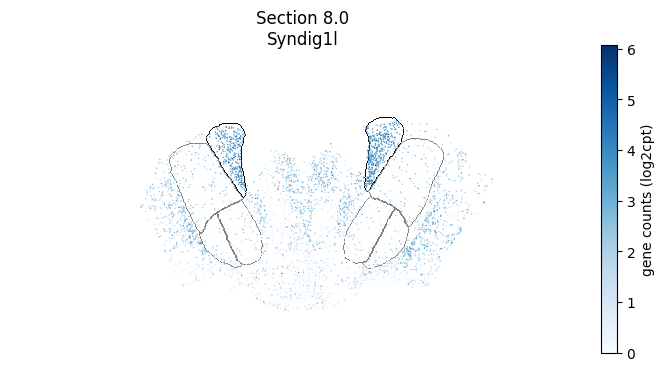

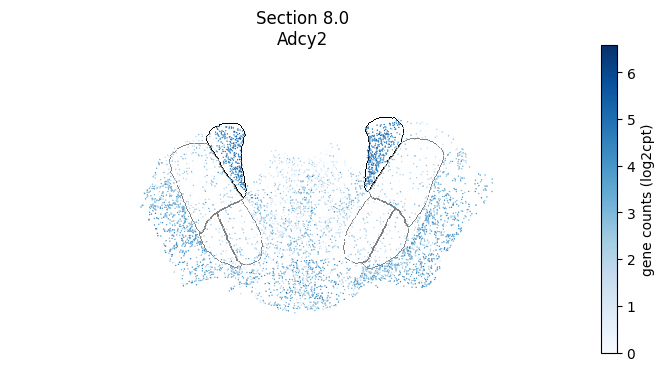

In [33]:
# show outlines for all the ATN
nuclei_ATN = ['AD', 'AV', 'AMd', 'AMv']
# highlight AD in black
nuclei_highlight = ['AD']

# we set n_de_genes_to_plot=2 at the top of this notebook
for gene in degs_top_pos[:n_de_genes_to_plot]:
    cplots.plot_expression_ccf(adata, 
                               gene, 
                               ccf_images,
                               sections=sections_ATN, # plot the example section defined above
                               nuclei=nuclei_ATN, 
                               highlight=nuclei_highlight,
                               **kwargs_ATN_expr)

#### AD clusters - 2613 vs. 2614

We can also use scanpy's gene group analysis to compare one group of cells to 
another specific group of cells

Here, since AD has two clusters that divide the nucleus into roughly half, we 
compare the two AD clusters, by setting `groups` to one cluster and `reference` 
to the other cluster.

We can then plot the top DEGs that are highly expressed in the first AD cluster
(the one passed to `groups`) as compared to the second AD cluster.

/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py:1017: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


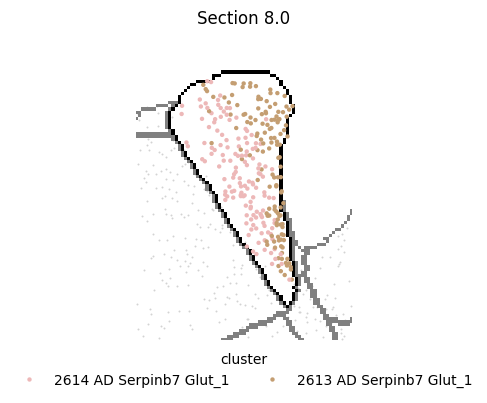

In [34]:
# get & plot AD-specific clusters
obs_AD = abc.get_obs_from_annotated_clusters('AD', adata.obs)

# set kwargs
kwargs_cells_AD = dict(
    bg_cells=adata.obs,
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    face_palette=None,
    edge_color='grey',
    point_size=10,  # increase cell marker size for smaller plot from custom_xy_lims
    custom_xy_lims=[4.4,5.1, 5.6,4.6]  # [xmin, xmax, ymin, ymax] for AD
    )


taxonomy_levels = ['cluster']
figs_ATN = cplots.plot_ccf_overlay(obs_AD, 
                                    ccf_images, 
                                    ccf_highlight=['AD'],
                                    point_hue=level, 
                                    sections=sections_ATN,
                                    point_palette=abc_palettes[level],
                                    legend='cells',
                                    **kwargs_cells_AD)

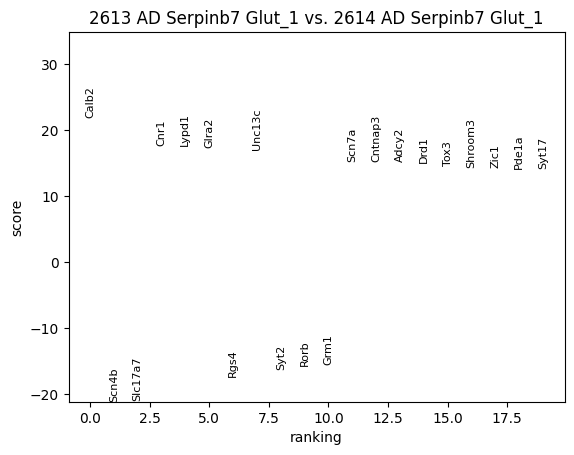


Top 20 DEGs for ['2613 AD Serpinb7 Glut_1'] vs 2614 AD Serpinb7 Glut_1:
 ['Calb2', 'Scn4b', 'Slc17a7', 'Cnr1', 'Lypd1', 'Glra2', 'Rgs4', 'Unc13c', 'Syt2', 'Rorb', 'Grm1', 'Scn7a', 'Cntnap3', 'Adcy2', 'Drd1', 'Tox3', 'Shroom3', 'Zic1', 'Pde1a', 'Syt17']

Top 10 positive DEGs for ['2613 AD Serpinb7 Glut_1'] vs 2614 AD Serpinb7 Glut_1:
 ['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn7a', 'Cntnap3', 'Adcy2', 'Drd1', 'Tox3']

Top 10 negative DEGs for ['2613 AD Serpinb7 Glut_1'] vs 2614 AD Serpinb7 Glut_1:
 ['Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Shox2', 'Kcnab3', 'Sorcs3', 'Rgs6']


In [35]:
taxonomy_level = 'cluster'
AD_cluster_labels = ['2613 AD Serpinb7 Glut_1', '2614 AD Serpinb7 Glut_1']

# Run DEG analysis for the two AD clusters
(degs_top_all, 
degs_top_pos, 
degs_top_neg) = run_sc_deg_analysis(adata, 
                                    taxonomy_level, 
                                    groups=[AD_cluster_labels[0]], 
                                    reference=AD_cluster_labels[1],
                                    save_to_key=key)

##### Plot 2613 (medial) DEGs

When we plot the expression of the top DEGs, we can use the `custom_xy_lims` 
parameter to zoom in and focus on just AD.

The positive ranked genes (`degs_top_pos`) from `sc.get.rank_genes_groups_df` 
are more highly expressed in the cluster passed to the `groups` parameter.

In [36]:
kwargs_expr_AD = dict(
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    cmap='Blues',
    edge_color='grey',
    point_size=10,  # increase cell marker size for smaller plot from custom_xy_lims
    custom_xy_lims=[4.4,5.1, 5.6,4.6], # [xmin, xmax, ymin, ymax] for AD
    )

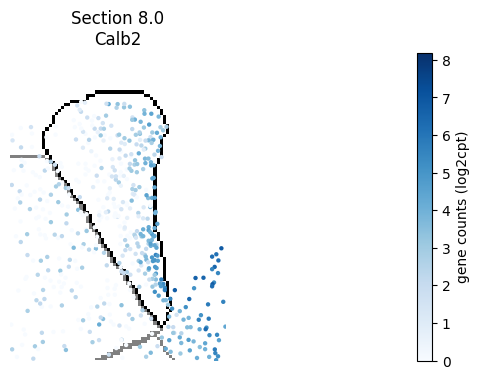

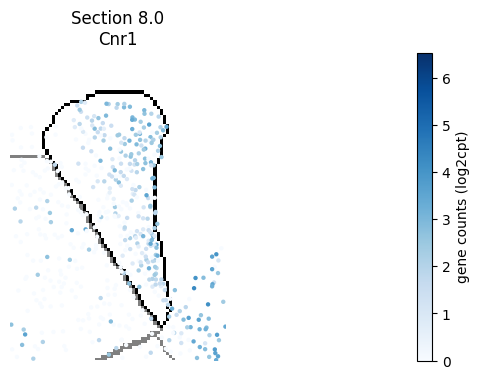

In [37]:
for gene in degs_top_pos[:n_de_genes_to_plot]:
    cplots.plot_expression_ccf(adata, 
                               gene, 
                               ccf_images,
                               sections=sections_ATN, # plot the example section defined above
                               nuclei=nuclei_ATN, 
                               highlight=nuclei_highlight,
                               **kwargs_expr_AD)

##### Plot 2614 (lateral) DEGs

The negative ranked genes (`degs_top_neg`) from `sc.get.rank_genes_groups_df` 
are more highly expressed in the cluster passed to the `reference` parameter.

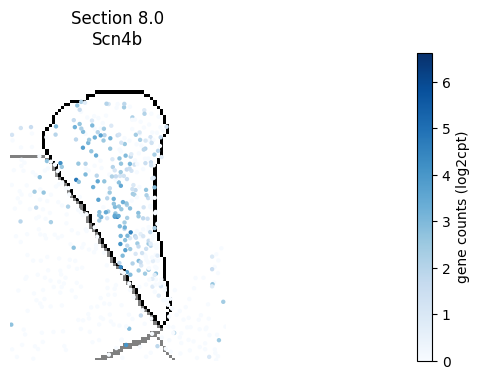

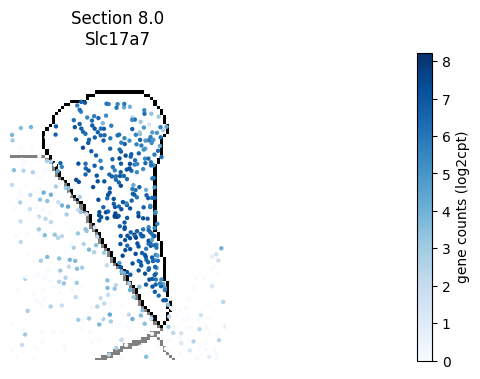

In [38]:
for gene in degs_top_neg[:n_de_genes_to_plot]:
    cplots.plot_expression_ccf(adata, 
                               gene, 
                               ccf_images,
                               sections=sections_ATN, # plot the example section defined above
                               nuclei=nuclei_ATN, 
                               highlight=nuclei_highlight,
                               **kwargs_expr_AD)

#### AV subclass vs. rest of subclasses

We can repeat this analysis for AV.

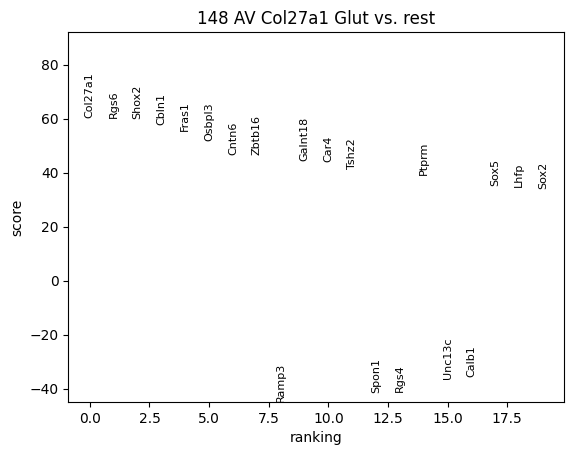


Top 20 DEGs for ['148 AV Col27a1 Glut'] vs rest:
 ['Col27a1', 'Rgs6', 'Shox2', 'Cbln1', 'Fras1', 'Osbpl3', 'Cntn6', 'Zbtb16', 'Ramp3', 'Galnt18', 'Car4', 'Tshz2', 'Spon1', 'Rgs4', 'Ptprm', 'Unc13c', 'Calb1', 'Sox5', 'Lhfp', 'Sox2']

Top 10 positive DEGs for ['148 AV Col27a1 Glut'] vs rest:
 ['Col27a1', 'Rgs6', 'Shox2', 'Cbln1', 'Fras1', 'Osbpl3', 'Cntn6', 'Zbtb16', 'Galnt18', 'Car4']

Top 10 negative DEGs for ['148 AV Col27a1 Glut'] vs rest:
 ['Ramp3', 'Spon1', 'Rgs4', 'Unc13c', 'Calb1', 'Tox', 'Fign', 'Grik1', 'Tafa4', 'Sulf2']


In [39]:
# AV subclass - 148 AV Col27a1 Glut
taxonomy_level = 'subclass'
key = 'AV_subclass_vs_rest'

# Run DEG analysis for AV subclass vs rest
(degs_top_all, 
degs_top_pos, 
degs_top_neg) = run_sc_deg_analysis(adata, 
                                    taxonomy_level, 
                                    groups=['148 AV Col27a1 Glut'], 
                                    reference='rest',
                                    save_to_key=key)

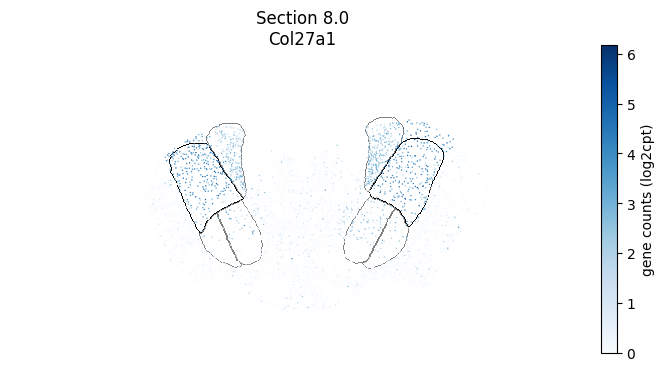

In [40]:
# show outlines for all the ATN
nuclei_ATN = ['AD', 'AV', 'AMd', 'AMv']
# highlight AD in black
nuclei_highlight = ['AV']

# we set n_de_genes_to_plot=2 at the top of this notebook
for gene in degs_top_pos[:n_de_genes_to_plot-1]:
    cplots.plot_expression_ccf(adata, 
                               gene, 
                               ccf_images,
                               sections=sections_ATN, # plot the example section defined above
                               nuclei=nuclei_ATN, 
                               highlight=nuclei_highlight,
                               **kwargs_ATN_expr)

#### AV clusters - 2615 vs. 2616

/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py:1017: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


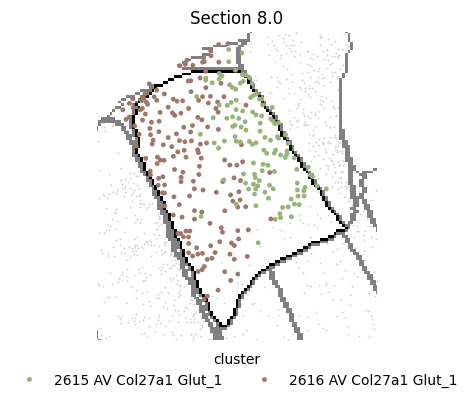

In [41]:
# get & plot AV-specific clusters
obs_AV = abc.get_obs_from_annotated_clusters('AV', adata.obs)

# set kwargs
kwargs_cells_AV = dict(
    bg_cells=adata.obs,
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    face_palette=None,
    edge_color='grey',
    point_size=12,  # increase cell marker size for smaller plot from custom_xy_lims
    custom_xy_lims=[4.0, 5.0, 5.9, 4.8]  # [xmin, xmax, ymin, ymax] for AV
    )


taxonomy_levels = ['cluster']
figs_ATN = cplots.plot_ccf_overlay(obs_AV, 
                                    ccf_images, 
                                    ccf_highlight=['AV'],
                                    point_hue=level, 
                                    sections=sections_ATN,
                                    point_palette=abc_palettes[level],
                                    legend='cells',
                                    **kwargs_cells_AV)


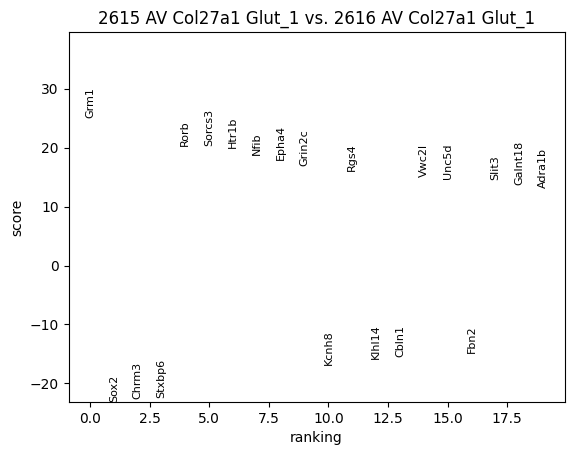


Top 20 DEGs for ['2615 AV Col27a1 Glut_1'] vs 2616 AV Col27a1 Glut_1:
 ['Grm1', 'Sox2', 'Chrm3', 'Stxbp6', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib', 'Epha4', 'Grin2c', 'Kcnh8', 'Rgs4', 'Klhl14', 'Cbln1', 'Vwc2l', 'Unc5d', 'Fbn2', 'Slit3', 'Galnt18', 'Adra1b']

Top 10 positive DEGs for ['2615 AV Col27a1 Glut_1'] vs 2616 AV Col27a1 Glut_1:
 ['Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib', 'Epha4', 'Grin2c', 'Rgs4', 'Vwc2l', 'Unc5d']

Top 10 negative DEGs for ['2615 AV Col27a1 Glut_1'] vs 2616 AV Col27a1 Glut_1:
 ['Sox2', 'Chrm3', 'Stxbp6', 'Kcnh8', 'Klhl14', 'Cbln1', 'Fbn2', 'Npsr1', 'Tnnt1', 'Chrm2']


In [42]:
# AV clusters - '2615 AV Col27a1 Glut_1', '2616 AV Col27a1 Glut_1'
AV_cluster_labels = obs_AV['cluster'].unique().tolist()
taxonomy_level = 'cluster'

# Run DEG analysis for the two AV clusters
(degs_top_all, 
degs_top_pos, 
degs_top_neg) = run_sc_deg_analysis(adata, 
                                    taxonomy_level, 
                                    groups=[AV_cluster_labels[0]], 
                                    reference=AV_cluster_labels[1],
                                    save_to_key=key)

##### Plot 2615 (medial cluster) DEGs

In [43]:
kwargs_expr_AV = dict(
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    cmap='Blues',
    edge_color='grey',
    point_size=10,  # increase cell marker size for smaller plot from custom_xy_lims
    custom_xy_lims=[4.0,5.0, 5.9,4.8]  # [xmin, xmax, ymin, ymax] for AV
    )

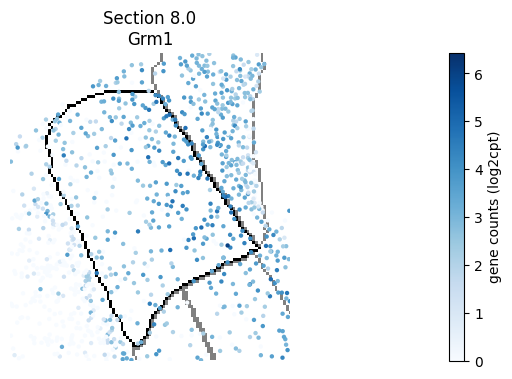

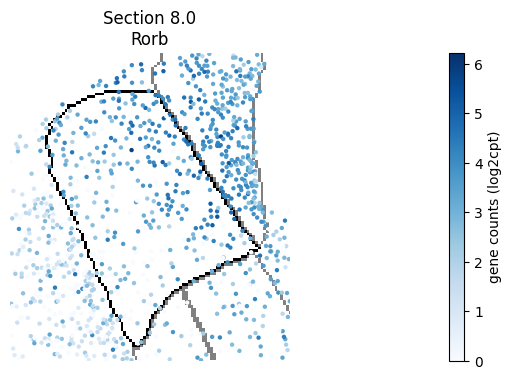

In [44]:
for gene in degs_top_pos[:n_de_genes_to_plot]:
    cplots.plot_expression_ccf(adata, 
                               gene, 
                               ccf_images,
                               sections=sections_ATN, # plot the example section defined above
                               nuclei=nuclei_ATN, 
                               highlight='AV',
                               **kwargs_expr_AV)

##### Plot 2616 (lateral cluster) DEGs

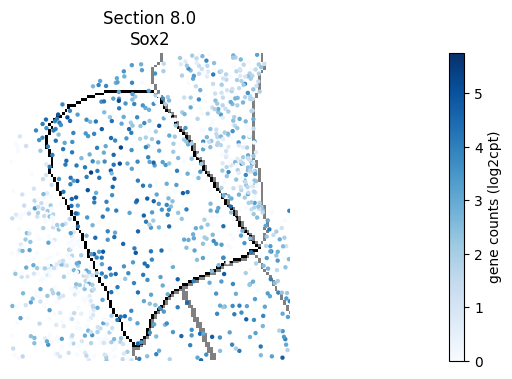

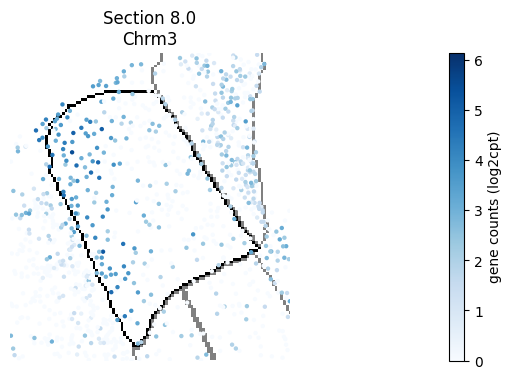

In [45]:
for gene in degs_top_neg[:n_de_genes_to_plot]:
    cplots.plot_expression_ccf(adata, 
                               gene, 
                               ccf_images,
                               sections=sections_ATN, # plot the example section defined above
                               nuclei=nuclei_ATN, 
                               highlight='AV',
                               **kwargs_expr_AV)

### AM supertype vs. rest

We leave the DEG analysis of AM as an exercise to the reader.

/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py:1017: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


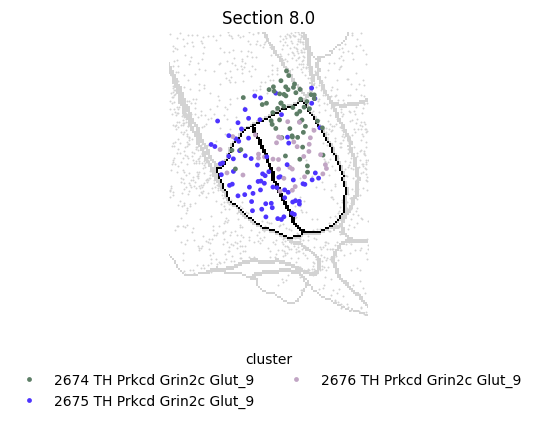

In [46]:
# get & plot AV-specific clusters
obs_AM = abc.get_obs_from_annotated_clusters('AM', adata.obs)

# set kwargs
kwargs_cells_AM = dict(
    bg_cells=adata.obs,
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    face_palette=None,
    edge_color='lightgrey',
    point_size=12,  # increase cell marker size for smaller plot from custom_xy_lims
    custom_xy_lims=[4.2, 5.2, max(obs_AM[y_col]),min(obs_AM[y_col])]  # [xmin, xmax, ymin, ymax] for AM
    )


taxonomy_levels = ['cluster']
figs_ATN = cplots.plot_ccf_overlay(obs_AM, 
                                    ccf_images, 
                                    ccf_highlight=['AMv', 'AMd'],
                                    point_hue=level, 
                                    sections=sections_ATN,
                                    point_palette=abc_palettes[level],
                                    legend='cells',
                                    **kwargs_cells_AM)

## 3.) View HCR / Multi-Gene Experiment Simulation

Finally, you can view 3 (or more!) genes as a simulation of a multi-gene / HCR experiment.

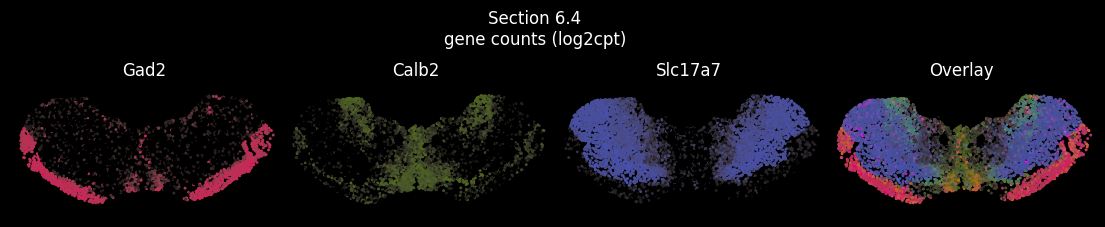

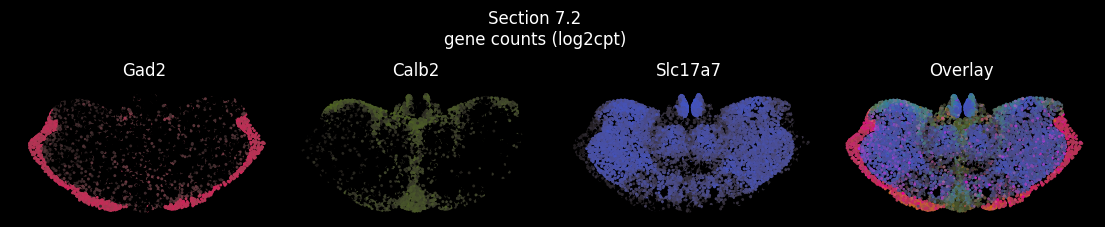

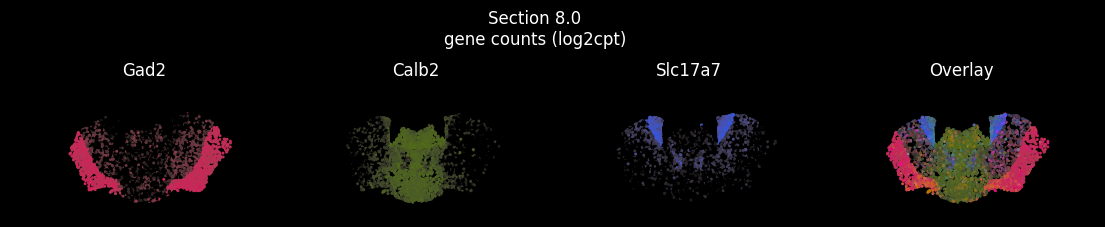

In [47]:
# Plot expression of 3 MERFISH genes as a simulation of an HCR experiment, 
# including a 3 separate and 1 overlay panels
geneList = ['Gad2', 'Calb2', 'Slc17a7']

# default is a white background
figs_hcr = cplots.plot_hcr(adata, 
                           geneList, 
                        #    colors=['blue', 'green', 'red'],
                           sections=sections_3, 
                           section_col=z_col,
                           x_col=x_col,
                           y_col=y_col,
                           )

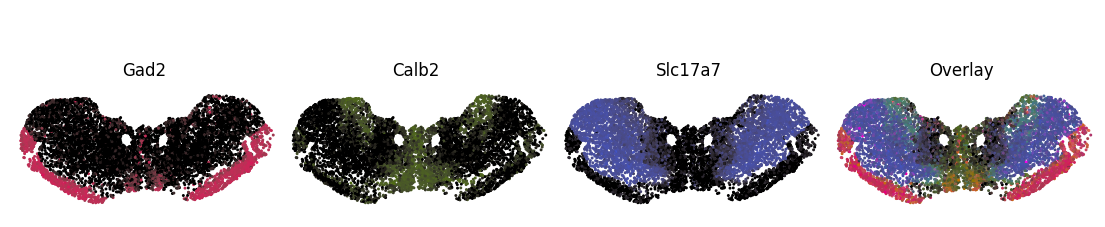

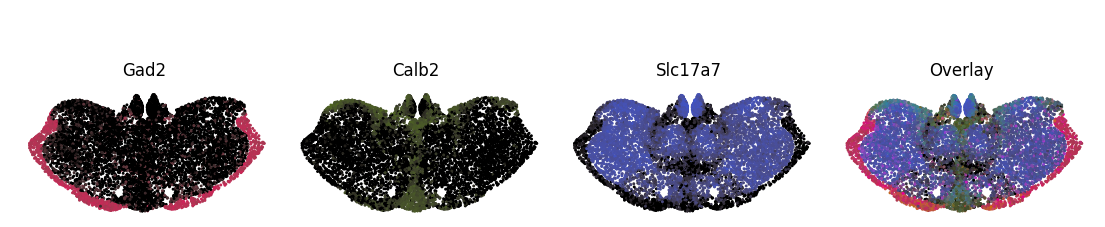

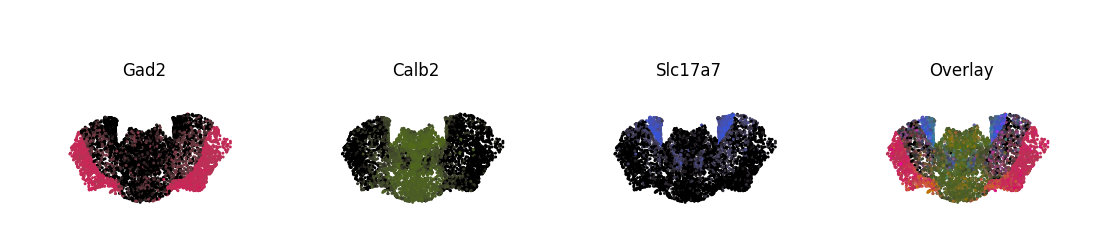

In [48]:
# you can also display with a light background 
figs_hcr = cplots.plot_hcr(adata, 
                           geneList, 
                           sections=sections_3, 
                           section_col=z_col,
                           x_col=x_col, 
                           y_col=y_col,
                           dark_background=False)